# Análisis Factorial Exploratorio

In [4]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

Extrayendo los puntajes del cuestionario Big Five Inventory (BFI), que evalúa cinco grandes dimensiones de la personalidad humana:
- Dimensiones del BFI:

    - A – Amabilidad (Apertura)

    - C – Responsabilidad (Conciencia)

    - E – Extraversión (Extraversión)

    - N – Neuroticismo (Neuroticismo)

    - O – Apertura a la experiencia (Amabilidad)

- Cada dimensión tiene 5 ítems, etiquetados como A1 a A5, C1 a C5, etc.

- Variables adicionales:

    - gender: Género del participante

    - age: Edad

In [5]:
df_resultados = pd.read_csv("../data/bfi_puntajes.csv")
df_resultados.head()

,id,A1,A2,A3,A4,A5,C1,C2,C3,C4,...,N3,N4,N5,O1,O2,O3,O4,O5,gender,age
0,1,4,4.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,...,2.0,3.0,3.0,1.0,1.0,2.0,3.0,4.0,1,16
1,2,3,4.0,3.0,3.0,5.0,3.0,1.0,1.0,2.0,...,4.0,2.0,2.0,5.0,4.0,5.0,5.0,3.0,2,18
2,3,3,4.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,...,4.0,3.0,2.0,2.0,2.0,3.0,2.0,1.0,2,17
3,4,4,3.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,...,4.0,4.0,4.0,2.0,3.0,3.0,2.0,2.0,2,17
4,5,4,5.0,4.0,3.0,5.0,3.0,4.0,3.0,3.0,...,4.0,4.0,4.0,3.0,4.0,5.0,2.0,3.0,1,17


### Seleccionando solo las columnas de los ítems del BFI (25 ítems, de A1 a O5)
- Indicando sus dimensiones

In [6]:
bfi_items = ['A1', 'A2', 'A3', 'A4', 'A5',  # Apertura
             'C1', 'C2', 'C3', 'C4', 'C5',  # Conciencia
             'E1', 'E2', 'E3', 'E4', 'E5',  # Extraversión
             'N1', 'N2', 'N3', 'N4', 'N5',  # Neuroticismo
             'O1', 'O2', 'O3', 'O4', 'O5']  # Amabilidad
df_bfi = df_resultados[bfi_items]

### Índice de Adecuación Muestral de Kaiser-Meyer-Olkin (KMO)
$$
KMO \geq 0.90 \Rightarrow \text{Excelente}
$$

$$
KMO \geq 0.80 \Rightarrow \text{Muy bueno}
$$

$$
KMO \geq 0.70 \Rightarrow \text{Bueno}
$$

$$
KMO \geq 0.60 \Rightarrow \text{Aceptable}
$$

$$
KMO \geq 0.50 \Rightarrow \text{Límite}
$$

$$
KMO < 0.50 \Rightarrow \text{Inadecuado para análisis factorial}
$$

### Prueba de esfericidad de Bartlett

Verifica si la matriz de correlaciones es significativamente diferente de una matriz identidad. Es decir evalúa si las variables están significativamente correlacionadas para justificar la aplicación del análisis factorial.

📌 **Hipótesis evaluadas**:

- **Hipótesis nula (H₀):** La matriz de correlaciones es una matriz identidad (es decir, no hay correlaciones significativas entre las variables).
- **Hipótesis alternativa (H₁):** La matriz de correlaciones no es una matriz identidad (hay correlaciones significativas entre las variables).




- Si $p-value < 0.05$, **se rechaza la hipótesis nula** $\Rightarrow$ **existen correlaciones significativas entre las variables y que el análisis factorial es apropiado.**.

- Si $p-value \geq 0.05$, **no se rechaza la hipótesis nula** $\Rightarrow$ **no hay suficientes correlaciones para aplicar análisis factorial**.

Indice KMO y prueba de esfericidad de Bartlett aplicado a todos lo Items
- El resultado es favorable para la aplicación del análisis factorial exploratorio

In [7]:
kmo_all, kmo_model = calculate_kmo(df_bfi)
print(f"KMO: {kmo_model}")  # Debe ser > 0.6
chi_square_value, p_value = calculate_bartlett_sphericity(df_bfi)
print(f"Bartlett's test: chi-square = {chi_square_value}, p-value = {p_value}")  # p < 0.05

KMO: 0.7679727996675568
Bartlett's test: chi-square = 9092.857665881811, p-value = 0.0


### Funciones

#### - Varianza total explicada

In [8]:
def dist_varianza(df, ev, name:str, factors:int):
    n_factors = factors
    # Análisis factorial exploratorio (AFE) sin aplicar ninguna rotación.
    fa_ex = FactorAnalyzer(rotation=None)
    fa_ex.fit(df)
    # Análisis factorial exploratorio (AFE) con rotación Varimax.
    fa_rot = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa_rot.fit(df)
    # Cargas factoriales iniciales
    loadings_ex = fa_ex.loadings_
    # Cargas factoriales con rotación
    loadings_rot = fa_rot.loadings_
    # Porcentaje de varianza explicada por cada eigenvalue (ev)
    ev_pct = (ev/(sum(ev)))*100
    ev_cum = ev_pct.cumsum()
    # Sumas de cargas al cuadrado (extracción y rotación)
    sum_sq_extraction = np.sum(loadings_ex**2, axis=0)
    sum_sq_rotation = np.sum(loadings_rot**2, axis=0)
    # Tabla de resultados
    resultados = list(zip(
        range(1, len(ev)+1),
        ev.round(3),
        ev_pct.round(3),
        ev_cum.round(3),
        [sum_sq_extraction[i] if i < len(sum_sq_extraction) else "-" for i in range(len(ev))],
        [sum_sq_rotation[i] if i < n_factors else "-" for i in range(len(ev))]))
    columns = pd.MultiIndex.from_product(
        [[f"Varianza total explicada: {name}"],
        ["Componente","Autovalores","% de varianza","% acumulado","Sumas cargas extracción","Sumas cargas rotación"]])
    tabla = pd.DataFrame(resultados, columns=columns)
    return tabla

#### - Gráfico de sedimentación

In [9]:
def plot_eigen(ev, sub:str):
    components = range(1, len(ev)+1)
    # Graficar scree plot para decidir el número de factores
    plt.figure(figsize=(8, 6))
    plt.plot(components, ev, marker='o')
    for i in range(len(ev)):
        plt.text(components[i]+0.1, ev[i], str(round(ev[i],4)))
    plt.title(f'Distribución_{sub}')
    plt.xlabel('Factores')
    plt.ylabel('Eigenvalues')
    plt.axhline(y=1, color='r', linestyle='--')  # Criterio de Kaiser (eigenvalue > 1)
    plt.xticks(range(1,7))
    plt.grid(True)
    plt.show()

#### - Cargas de los factores

In [10]:
def loadings(fa, df, name):
    factor_values = [val[0] for val in fa.loadings_]
    load_varimax =  pd.DataFrame(zip(df.columns, factor_values), columns=["item","Factor_1"])
    load_varimax["Subescala"] = name.capitalize()
    return load_varimax

### Separando los items por dimensiones

In [11]:
dimensiones = {
    "apertura": df_bfi[['A1', 'A2', 'A3', 'A4', 'A5']],
    "conciencia": df_bfi[['C1', 'C2', 'C3', 'C4', 'C5']],
    "extraversion": df_bfi[['E1', 'E2', 'E3', 'E4', 'E5']],
    "neuroticismo": df_bfi[['N1', 'N2', 'N3', 'N4', 'N5']],
    "amabilidad": df_bfi[['O1', 'O2', 'O3', 'O4', 'O5']]
}

### Alpha de cronbach de las dimensiones de la prueba BIF antes del AFE (Análisis factorial exploratorio)

$$
\text{Coeficiente alfa} \geq 0.90 \Rightarrow \text{excelente}
$$

$$
\text{Coeficiente alfa} > 0.80 \Rightarrow \text{bueno}
$$

$$
\text{Coeficiente alfa} > 0.70 \Rightarrow \text{aceptable}
$$

$$
\text{Coeficiente alfa} > 0.60 \Rightarrow \text{cuestionable}
$$

$$
\text{Coeficiente alfa} > 0.50 \Rightarrow \text{pobre}
$$

$$
\text{Coeficiente alfa} \leq 0.50 \Rightarrow \text{inaceptable}
$$

Alpha de cronbach aplicado a cada dimensión.

- El resultado se encuentra en el límite aceptable

In [12]:
for name, dim in dimensiones.items():
    alpha_test = pg.cronbach_alpha(dim)[0]
    print(f"Alfa de cronbach total {name}: {alpha_test:.3f}") 

Alfa de cronbach total apertura: 0.550
Alfa de cronbach total conciencia: 0.693
Alfa de cronbach total extraversion: 0.697
Alfa de cronbach total neuroticismo: 0.687
Alfa de cronbach total amabilidad: 0.690


## KMO por dimensiones

In [13]:
from factor_analyzer import FactorAnalyzer
fa_fit = {}
eigenvalues = {}
v_value = {}
for i, dim in dimensiones.items():
    kmo_all, kmo_model = calculate_kmo(dim)
    print(f"KMO_{i}: {kmo_model}")  # Debe ser > 0.6
    chi_square_value, p_value = calculate_bartlett_sphericity(dim)
    print(f"Bartlett's test: chi-square = {chi_square_value}, p-value = {p_value}")  # p < 0.05
    print("="*50)
    fa = FactorAnalyzer(rotation="varimax", n_factors=1)
    fa_fit[f"fa_{i}"] = fa.fit(dim)
    ev, v = fa.get_eigenvalues()  # Obtener eigenvalues
    eigenvalues[f"ev_{i}"] = ev
    v_value[f"v_{i}"] = v

KMO_apertura: 0.717477461790012
Bartlett's test: chi-square = 1245.0035229799562, p-value = 2.818812731484923e-261
KMO_conciencia: 0.7871361043980334
Bartlett's test: chi-square = 1919.8047303559445, p-value = 0.0
KMO_extraversion: 0.7890178931374251
Bartlett's test: chi-square = 1962.467608906156, p-value = 0.0
KMO_neuroticismo: 0.7831968606354952
Bartlett's test: chi-square = 1858.4297511529041, p-value = 0.0
KMO_amabilidad: 0.7852462531810428
Bartlett's test: chi-square = 1883.0470417525282, p-value = 0.0


## Gráfico de sedimentación (scree plot) mostrando los autovalores por factor.

En la descomposición de la matriz de correlaciones entre las variables se obtienen los autovalores (eigenvalues), el cual indican cuanta varianza explica cada factor.

Pero solo se retendran los factores con autovalores mayores que 1, ya que cada factor debe explicar al menos tanta varianza como una variable original, según el criterio de Kaiser.

-  Todos los factores presentan autovalores mayores a 1, excepto la primera dimensión (Apertura), cuyo autovalor es apenas superior al umbral (1.0029). Aunque cumple el criterio de Kaiser, se priorizará el factor con mayor relevancia (1.9146), considerando la distribución de varianza y la interpretación teórica.

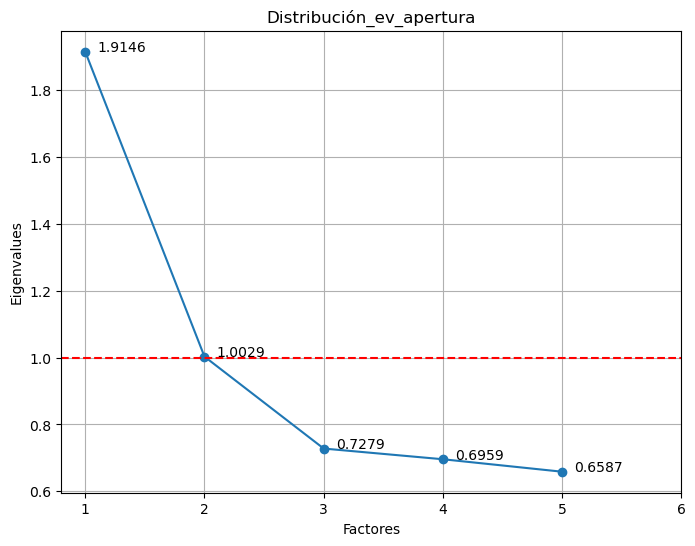

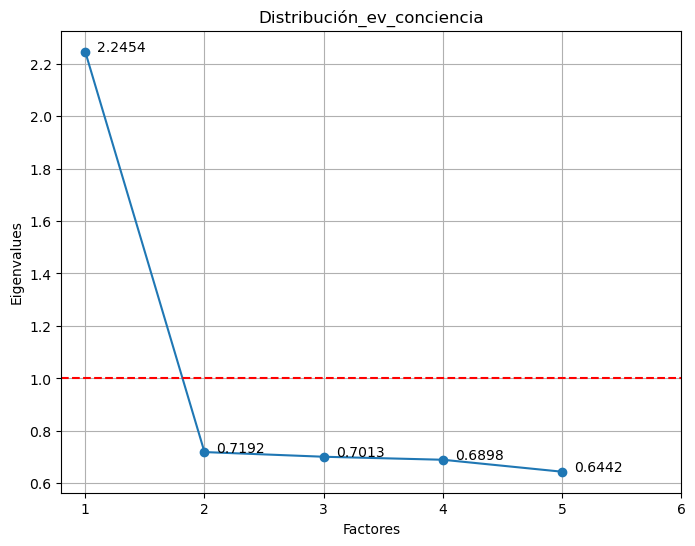

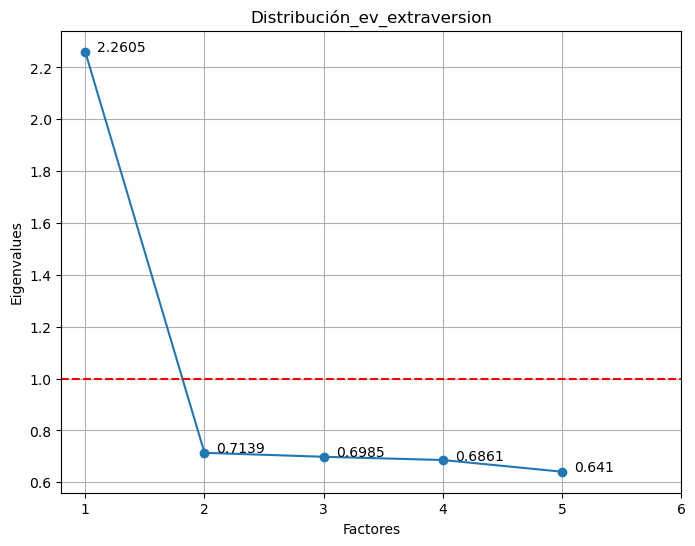

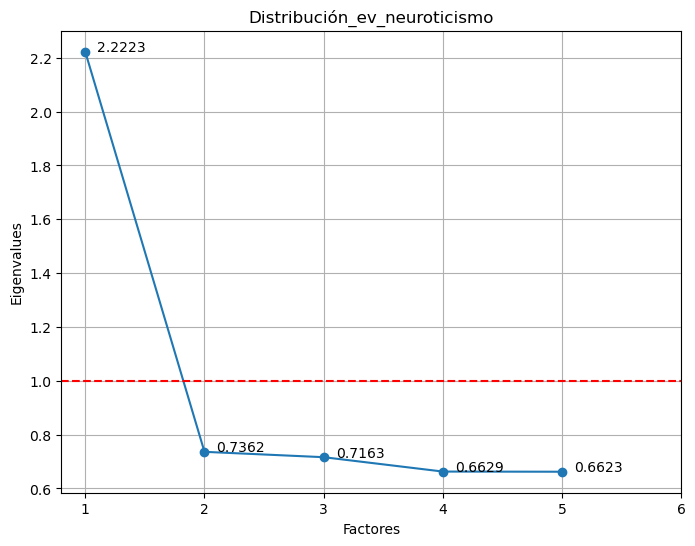

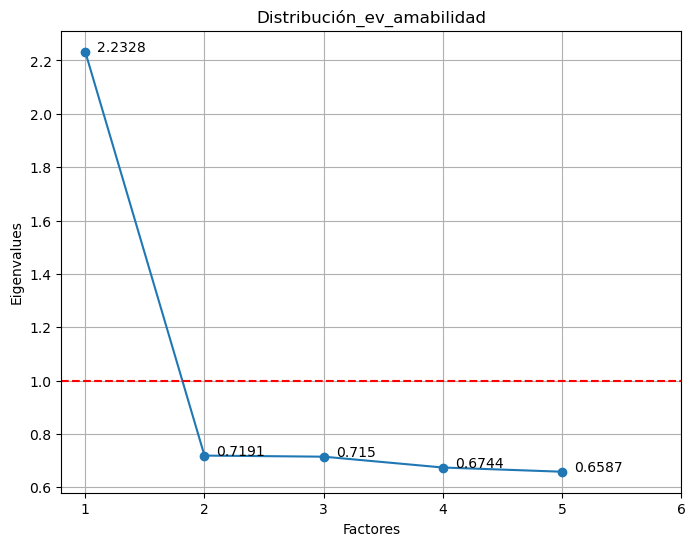

In [14]:
for name, ev in eigenvalues.items():
    plot_eigen(ev, name)

## Cargas de los factores

Las cargas factoriales indican cuánto influye una variable obervada (Ítem) a un factor latente.
Se interpretan por su valor absoluto, similar a una correlación (no exactamente lo mismo). Por ejemplo 0.8 significa que está fuertemente asociada con ese factor. 

Los signos negativos de las cargas indica que está inversamente relacionado con el factor. Puede ocurrir porque el ítem está redactado en sentido opuesto (por ejemplo, “Prefiero rutinas” en una escala de apertura)



- Los resultados muestran que son altas en valor absoluto ```> 0.50``` a excepción del Item **A1** que cuenta con un valor absoluto ```< 0.30```. Con respecto a los demás indican una fuerte relación con su único factor.

In [15]:
lista_df = list()
for fa, df in zip(fa_fit.items(), dimensiones.items()):
    lista_df.append(loadings(fa[1], df[1], df[0]))
df_unido = pd.concat(lista_df, axis=1, ignore_index=False)
print(df_unido.to_string())

  item  Factor_1 Subescala item  Factor_1   Subescala item  Factor_1     Subescala item  Factor_1     Subescala item  Factor_1   Subescala
0   A1 -0.003114  Apertura   C1 -0.550241  Conciencia   E1 -0.548633  Extraversion   N1 -0.547313  Neuroticismo   O1 -0.567654  Amabilidad
1   A2 -0.543682  Apertura   C2 -0.525064  Conciencia   E2 -0.594196  Extraversion   N2 -0.566102  Neuroticismo   O2 -0.561710  Amabilidad
2   A3 -0.579613  Apertura   C3 -0.574685  Conciencia   E3 -0.559753  Extraversion   N3 -0.515458  Neuroticismo   O3 -0.537395  Amabilidad
3   A4 -0.532390  Apertura   C4 -0.587107  Conciencia   E4 -0.537470  Extraversion   N4 -0.553040  Neuroticismo   O4 -0.565112  Amabilidad
4   A5 -0.552869  Apertura   C5 -0.552418  Conciencia   E5 -0.566484  Extraversion   N5 -0.581590  Neuroticismo   O5 -0.543741  Amabilidad


## Varianza explicada por dimensión

Porcentajes de la varianza explicada por cada factor tomando en cuenta algunos descriptivos como:

- **Componente**: el número del factor.
- **Autovalores**: cuánta varianza explica cada factor.
- **% de varianza**: proporción de la varianza total explicada por ese factor.
- **% acumulado:** suma progresiva de la varianza explicada por los factores.


- Solo se considera a los autovalores (eigenvalues) mayores a 1.

In [16]:
dist_varianza(dimensiones["apertura"], eigenvalues["ev_apertura"], "apertura", 1)

Varianza total explicada: apertura                                        \
                          Componente Autovalores % de varianza % acumulado   
0                                  1       1.915        38.291      38.291   
1                                  2       1.003        20.058      58.349   
2                                  3       0.728        14.559      72.908   
3                                  4       0.696        13.919      86.827   
4                                  5       0.659        13.173     100.000   

                                                 
  Sumas cargas extracción Sumas cargas rotación  
0                1.264276              1.220654  
1                0.075244                     -  
2                0.067943                     -  
3                       -                     -  
4                       -                     -

In [17]:
dist_varianza(dimensiones["conciencia"], eigenvalues["ev_conciencia"], "conciencia", 1)

Varianza total explicada: conciencia                                        \
                            Componente Autovalores % de varianza % acumulado   
0                                    1       2.245        44.908      44.908   
1                                    2       0.719        14.384      59.292   
2                                    3       0.701        14.027      73.318   
3                                    4       0.690        13.797      87.115   
4                                    5       0.644        12.885     100.000   

                                                 
  Sumas cargas extracción Sumas cargas rotación  
0                1.582284              1.558581  
1                0.052226                     -  
2                0.040254                     -  
3                       -                     -  
4                       -                     -

In [18]:
dist_varianza(dimensiones["extraversion"], eigenvalues["ev_extraversion"], "extraversion", 1)

Varianza total explicada: extraversion                            \
                              Componente Autovalores % de varianza   
0                                      1       2.261        45.211   
1                                      2       0.714        14.278   
2                                      3       0.699        13.971   
3                                      4       0.686        13.721   
4                                      5       0.641        12.819   

                                                             
  % acumulado Sumas cargas extracción Sumas cargas rotación  
0      45.211                1.599822              1.577169  
1      59.489                0.054598                     -  
2      73.460                0.034015                     -  
3      87.181                       -                     -  
4     100.000                       -                     -

In [19]:
dist_varianza(dimensiones["neuroticismo"], eigenvalues["ev_neuroticismo"], "neuroticismo", 1)

Varianza total explicada: neuroticismo                            \
                              Componente Autovalores % de varianza   
0                                      1       2.222        44.446   
1                                      2       0.736        14.724   
2                                      3       0.716        14.326   
3                                      4       0.663        13.257   
4                                      5       0.662        13.246   

                                                             
  % acumulado Sumas cargas extracción Sumas cargas rotación  
0      44.446                1.555664               1.52982  
1      59.171                0.063633                     -  
2      73.496                0.044064                     -  
3      86.754                       -                     -  
4     100.000                       -                     -

In [20]:
dist_varianza(dimensiones["amabilidad"], eigenvalues["ev_amabilidad"], "amabilidad", 1)

Varianza total explicada: amabilidad                                        \
                            Componente Autovalores % de varianza % acumulado   
0                                    1       2.233        44.655      44.655   
1                                    2       0.719        14.382      59.038   
2                                    3       0.715        14.300      73.338   
3                                    4       0.674        13.489      86.827   
4                                    5       0.659        13.173     100.000   

                                                 
  Sumas cargas extracción Sumas cargas rotación  
0                1.566191              1.541549  
1                0.054898                     -  
2                0.044026                     -  
3                       -                     -  
4                       -                     -

# Análisis Factorial Confirmatorio

### Definiendo el modelo teórico
- Estructura de factores e ítems (considerando a todos los ítems)

In [21]:
modelo = """
F1 =~ A1 + A2 + A3 + A4 + A5
F2 =~ C1 + C2 + C3 + C4 + C5
F3 =~ E1 + E2 + E3 + E4 + E5
F4 =~ N1 + N2 + N3 + N4 + N5
F5 =~ O1 + O2 + O3 + O4 + O5
"""

### Indicadores de ajuste

- **Chi² p-value**: Valor p asociado al chi².
    - Si p > 0.05, el modelo no difiere significativamente de los datos (buen ajuste)
- **CFI (Comparative Fit Index)**: Compara el modelo propuesto con el modelo base.
    - Valores > 0.95 indican buen ajuste.
- **TLI (Tucker-Lewis Index)**: Similar al CFI, pero penaliza por complejidad.
    - Valores > 0.95 indican buen ajuste.
- **RMSEA (Root Mean Square Error of Approximation)**: Mide el error de aproximación del modelo.
    - Valores < 0.06 son buenos, 0.06 a 0.08 aceptables, > 0.10 son malos.
- **AIC (Akaike Information Criterion)**: Evalúa la calidad del modelo penalizando la complejidad.
- **BIC (Bayesian Information Criterion)**: Similar al AIC, pero penaliza más la complejidad.

In [22]:
from semopy import Model

model = Model(modelo)
model.load_dataset(df_bfi)

# Ajustando el modelo a los datos
model.fit()
# Obteniendo las cargas factoriales y errores estándar
afc_summary = model.inspect()

from semopy import calc_stats
# Calculando los puntajes de ajuste del modelo
stats = calc_stats(model)
stats

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,265,300,263.176952,0.520094,9125.993721,1.000207,0.971162,0.967353,0.971162,1.000234,0,119.812016,476.054498,0.093992


- Se realiza la rotación con el método ```oblimin```, que permite la correlación entre factores, a diferencia del método ```varimax```, que busca factores ortogonales (independientes), es decir, que cada ítem tenga una carga alta en un solo factor y baja en los demás.

- Se especifican 5 factores en el modelo.

- Se extraen los autovalores (eigenvalues), que indican cuánta varianza explica cada factor.

In [23]:
from factor_analyzer import FactorAnalyzer
fa_cf = FactorAnalyzer(rotation="oblimin", n_factors=5, method='principal')
fa_cf.fit(df_bfi)
ev_cf, v_cf = fa_cf.get_eigenvalues()  # Obtener eigenvalues

Según el criterio de Kaiser, los autovalores mayores a 1 indican factores que explican una cantidad significativa de varianza, lo cual ayuda a decidir cuántos factores retiene el modelo.

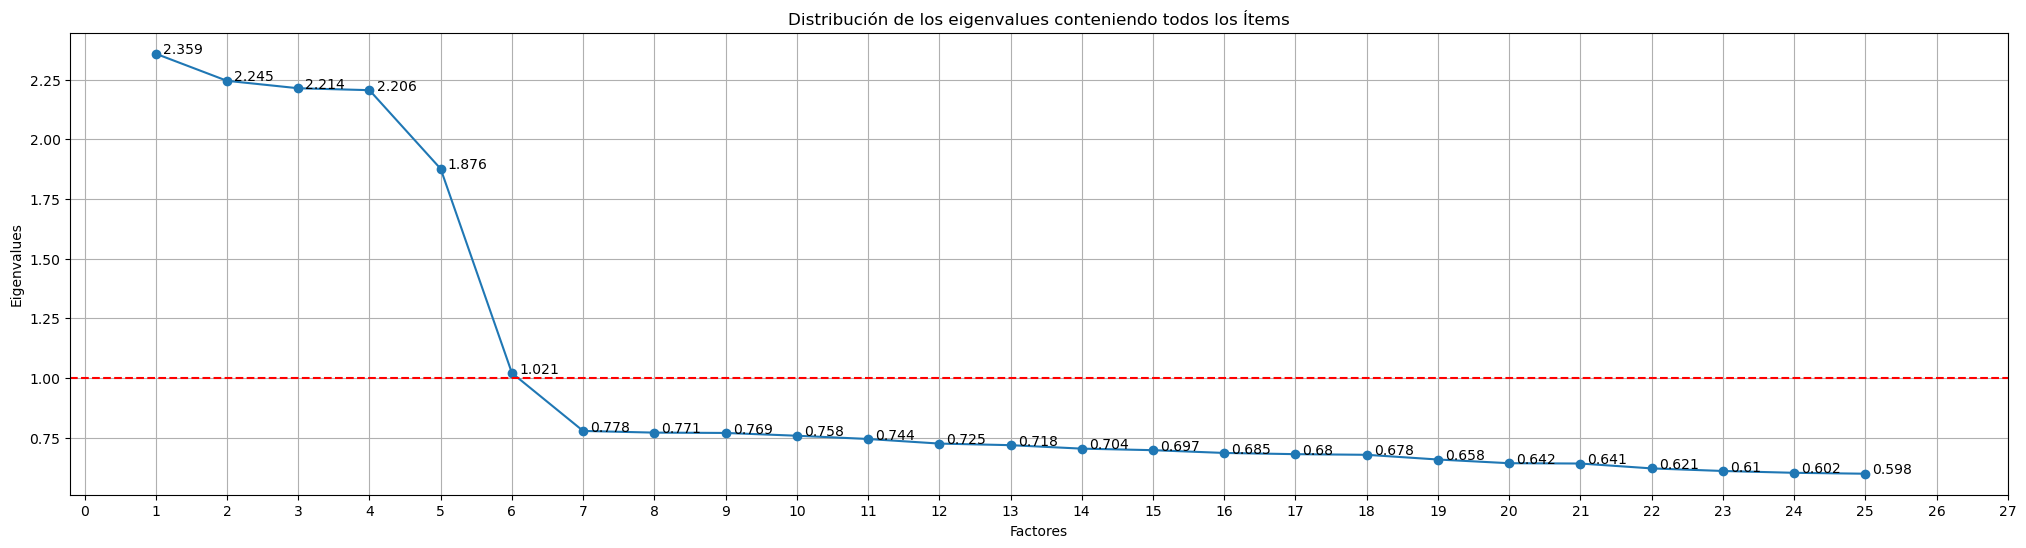

In [24]:
components = range(1, len(ev_cf)+1)
# Graficar scree plot para decidir el número de factores
plt.figure(figsize=(25, 6))
plt.plot(components, ev_cf, marker='o')
for i in range(len(ev_cf)):
    plt.text(components[i]+0.1, ev_cf[i], str(round(ev_cf[i],3)))
plt.xlabel('Factores')
plt.ylabel('Eigenvalues')
plt.title('Distribución de los eigenvalues conteniendo todos los Ítems')
plt.axhline(y=1, color='r', linestyle='--')  # Criterio de Kaiser (eigenvalue > 1)
plt.xticks(range(len(ev_cf)+3))
plt.grid(True)
plt.show()

### Descripción de las cargas factoriales

### Relaciones:

- Cargas factoriales

```A2 ~ F1```: Indica la fuerza de la relación entre el ítem A2 y el factor F1.

Cargas bajas (por ejemplo, < 0.30) suelen eliminarse por no representar bien el constructo.

- Varianzas residuales

```A4 ~~ A4```: Representa la varianza del ítem A4 no explicada por el factor, es decir, el error.

Valores altos indican que el ítem tiene mucha variabilidad no atribuida al factor.

- Covarianzas entre factores diferentes

```F1 ~~ F2```: Muestra la covarianza entre los factores F1 y F2.

Si es significativa, indica que los factores están relacionados, sino que son independientes.

- Varianza del mismo factor

```F1 ~~ F1```: Representa la varianza del factor F1 en el modelo.

Si este valor es muy bajo o no significativo, puede indicar que el factor no está bien definido o no está siendo medido adecuadamente por sus ítems.

**Resultados:**

- Los Items A2, A3, A4, A5 muestran una alto valor en p-value, se sugiere revisar la redacción de estos ítems o su eliminación
- El factor F1 parece débil, su varianza es muy baja y no significativa, y sus ítems (A2–A5) también tienen cargas no significativas.
- Los factores F2 a F5 tienen varianzas significativas, lo que indica que están bien definidos.
- Las covarianzas entre factores son no significativas, lo que sugiere que los factores son independientes.

In [25]:
afcsum_df = pd.DataFrame(afc_summary)
print("\nResumen del modelo AFC:")
afcsum_df.iloc[0:60,:]


Resumen del modelo AFC:


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,A1,~,F1,1.000000,-,-,-
1,A2,~,F1,46.266423,75.840937,0.610046,0.541832
2,A3,~,F1,49.743375,81.537887,0.610065,0.541819
3,A4,~,F1,45.265936,74.201814,0.610038,0.541837
4,A5,~,F1,46.615419,76.412471,0.61005,0.541829
5,C1,~,F2,1.000000,-,-,-
6,C2,~,F2,0.938676,0.05117,18.344244,0.0
7,C3,~,F2,1.041510,0.054043,19.271985,0.0
8,C4,~,F2,1.052750,0.054145,19.443325,0.0
9,C5,~,F2,0.995242,0.052782,18.855671,0.0


Se especificaron cinco factores en el modelo, y se analizaron las cargas factoriales para identificar el factor dominante en cada ítem.

In [26]:
loadings_df = pd.DataFrame(fa_cf.loadings_, index=df_bfi.columns, columns=[f"Factor_{i}" for i in range(1, fa_cf.loadings_.shape[1]+1)])
loadings_df["Factor dominante"] = loadings_df.abs().idxmax(axis=1)
loadings_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor dominante
A1,-0.017843,0.000311,0.053862,-0.033882,0.008100,Factor_3
A2,-0.009096,-0.008507,0.006245,-0.005213,0.686860,Factor_5
A3,0.012155,0.020947,-0.015356,0.026515,0.707699,Factor_5
A4,-0.006196,-0.010188,0.014413,-0.007941,0.679480,Factor_5
A5,-0.001747,-0.006366,-0.005633,-0.013171,0.690734,Factor_5
C1,0.665615,0.005728,0.000635,-0.033498,-0.004684,Factor_1
C2,0.644706,0.001585,-0.016463,0.034989,0.003477,Factor_1
C3,0.680086,-0.010354,0.011067,0.038285,-0.014332,Factor_1
C4,0.690995,0.013152,0.015181,-0.015756,0.013707,Factor_1
C5,0.666791,-0.009405,-0.013287,-0.023245,-0.002480,Factor_1


Eliminación de los ítems con que no cuentan con un valor significativo ```> 0.05``` y que cuenten con una carga en valor absoluto  ```< 0.3```.

Los Ítems que cumplen estas condiciones son los ítems de la dimensión Apertura, en un caso real se podría corregir su redacción.

In [27]:
modelo_1 = """
F2 =~ C1 + C2 + C3 + C4 + C5
F3 =~ E1 + E2 + E3 + E4 + E5
F4 =~ N1 + N2 + N3 + N4 + N5
F5 =~ O1 + O2 + O3 + O4 + O5
"""

### Comparación de los 2 modelos

$$
\text{primer modelo (Ítems completos)} \Rightarrow \ \text{segundo modelo (Ítems corregidos o eliminados)}
$$

$$
\text{CFI: }  1.0000 \Rightarrow \ .999 \text{ Ambos excelentes}
$$

$$
\text{TLI: }  1.0000 \Rightarrow \ .999 \text{ Ambos excelentes}
$$

$$
\text{AIC: }  119.81 \Rightarrow \ 91.88 \text{ Segundo modelo (menor)}
$$

$$
\text{BIC: }  476.05 \Rightarrow \ 364.99 \text{ Segundo modelo (menor)}
$$

$$
\text{RMSEA: }  0.000 \Rightarrow \ 0.003 \text{ Ambos excelentes}
$$

- El segundo modelo muestra mejores resultados ya que se corregiría o eliminaría los Ítems evaluados

In [28]:
from semopy import Model

model_1 = Model(modelo_1)
model_1.load_dataset(df_bfi.drop(["A1","A2","A3","A4","A5"], axis=1))

# Ajustar el modelo
model_1.fit()
# Obtener el resumen del ajuste del modelo AFC
afc_summary = model_1.inspect()

from semopy import calc_stats
stats = calc_stats(model_1)
stats

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,164,190,169.148945,0.375202,7785.409319,0.999322,0.978274,0.974829,0.978274,0.999215,0.003349,91.879179,364.998415,0.06041


In [29]:
from factor_analyzer import FactorAnalyzer
fa_cf1 = FactorAnalyzer(rotation="oblimin", n_factors=5, method='principal')
fa_cf1.fit(df_bfi.drop(["A1","A2","A3","A4","A5"], axis=1))
ev_cf1, v_cf1 = fa_cf1.get_eigenvalues()  # Obtener eigenvalues

Tras la eliminación de cinco ítems pertenecientes a una misma dimensión (Apertura). El gráfico muestra que los primeros cuatro eigenvalues son mayores a 1 (2.359, 2.243, 2.211 y 2.165), lo que indica que, según el criterio de Kaiser, la distribución de los Ítems se compone de cuatro factores.  En un caso real se consideraría corregir la redacción de los ítems, para este ejemplo se optó por su eliminación. A partir del quinto componente, los eigenvalues caen por debajo del umbral, por consecuencia no aportando varianza significativa

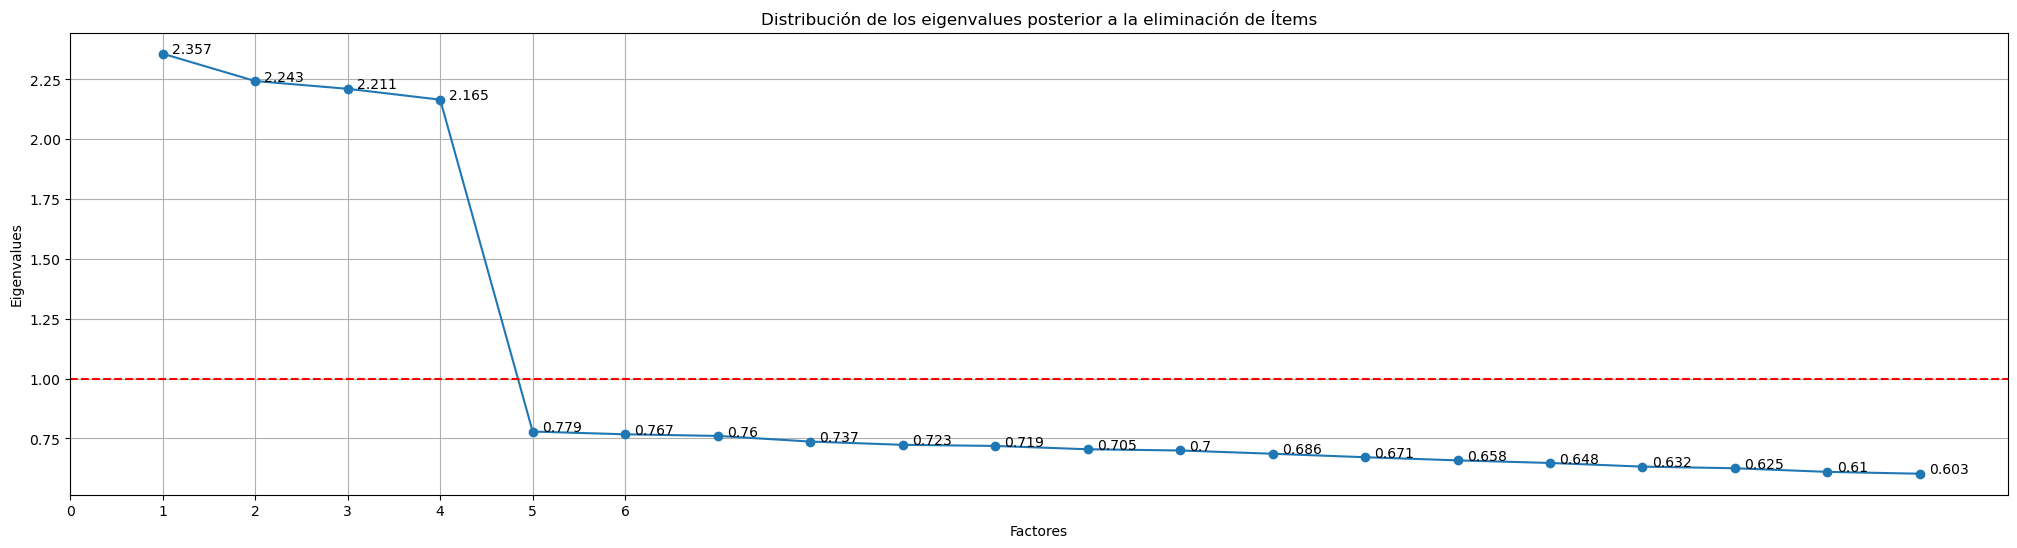

In [30]:
components = range(1, len(ev_cf1)+1)
# Graficar scree plot para decidir el número de factores
plt.figure(figsize=(25, 6))
plt.plot(components, ev_cf1, marker='o')
for i in range(len(ev_cf1)):
    plt.text(components[i]+0.1, ev_cf1[i], str(round(ev_cf1[i],3)))
plt.title('Distribución de los eigenvalues posterior a la eliminación de Ítems')
plt.xlabel('Factores')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--')  # Criterio de Kaiser (eigenvalue > 1)
plt.xticks(range(len(ev)+2))
plt.grid(True)
plt.show()

## **Resultado final:**

**Luego de eliminar los ítems que no cumplían con los criterios establecidos (que en un caso real se podrían redactar nuevamente), se realizó nuevamente el análisis factorial confirmatorio con rotación oblimin, especificando cuatro factores en el modelo.**

**Los resultados muestran una estructura factorial clara y diferenciada.**

In [31]:
loadings_df1 = pd.DataFrame(fa_cf1.loadings_, index=df_bfi.drop(["A1","A2","A3","A4","A5"], axis=1).columns, columns=[f"Factor_{i}" for i in range(1, fa_cf1.loadings_.shape[1]+1)])
loadings_df1["Factor dominante"] = loadings_df1.abs().idxmax(axis=1)
loadings_df1

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor dominante
C1,0.003196,0.023236,0.666025,-0.032172,-0.038065,Factor_3
C2,-0.014685,0.000998,0.644252,0.034624,0.001282,Factor_3
C3,0.004820,-0.081624,0.678432,0.034267,0.158213,Factor_3
C4,0.013630,-0.006019,0.690669,-0.014983,0.041506,Factor_3
C5,-0.005928,0.067376,0.669082,-0.017134,-0.171406,Factor_3
E1,0.661933,-0.016059,0.017195,-0.027032,0.050616,Factor_1
E2,0.698050,0.020267,0.007832,0.039714,-0.111392,Factor_1
E3,0.660908,-0.107438,-0.002440,-0.023557,0.266392,Factor_1
E4,0.663397,0.096166,-0.010088,0.006428,-0.194139,Factor_1
E5,0.675934,0.026973,-0.007081,-0.000745,0.007792,Factor_1
